In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-ultimate-halloween-candy-power-ranking/candy-data.csv


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# **Coordinate Descent for Log Loss Minimization**

Let's consider a logistic regression model with parameters $\mathbf{w} = (w_1, w_2, \dots, w_d)$. We want to minimize the log loss function over a training dataset with $n$ samples. The log loss function for a single sample $(x_i, y_i)$ is defined as:

\begin{equation}
L(w; x_i, y_i) = -y_i \log(h(w^T x_i)) - (1 - y_i) \log(1 - h(w^T x_i))
\end{equation}
where:

* $h(w^T x_i)$ is the sigmoid function evaluated at the linear combination of weights and features for sample $i$
* $y_i$ is the true label for sample $i$ (either 0 or 1)

The overall log loss for the entire dataset is:

\begin{equation}
L(\mathbf{w}) = \frac{1}{n} \sum_{i=1}^{n} L(w; x_i, y_i)
\end{equation}

The coordinate descent algorithm for minimizing the log loss iteratively updates each weight $w_j$ as follows:


\begin{equation}
w_j^{k+1} = \arg \min_{w_j} L(\mathbf{w}^k_j, w_j, \mathbf{w}^k_{-j})
\end{equation}


where:

* $k$ is the iteration number
* $\mathbf{w}^k$ is the weight vector at iteration $k$
* $\mathbf{w}^k_j$ denotes all weights except $w_j$ at iteration $k$ (vector with the j-th element removed)
* $w_j^{k+1}$ is the updated value of weight $w_j$ at iteration $k+1$



# **Methodology**

I use the cross entropy loss or Log-Loss $L(w)$ in the coordinate descent method. Let $\hat{y}$ be the probability of predicting label 1, and let $y$ be the actual label. Then the cross entropy loss and gradient is defined below:

$$
L(w) = -\frac{1}{n}\displaystyle\sum_{i=1}^{n} y_{i} \log \hat{y}_{i} + (1 - y_{i}) \log(1 - \hat{y}_{i})
$$

And thus the gradients with respect with each weight $w_{j}$ is given by,

$$
\frac{\partial L(w)}{\partial w_{j}} = \displaystyle \sum_{i=1}^{n}(\hat{y}_{i} - y_{i})x_{j}
$$

The loss function $L(\bullet)$ should be differentiable and preferrably convex. The procedure of the Coordinate Descent method is outlined below:

1. Initialize weights to zero

2. Get predictions from sigmoid function

3. Calculate loss and gradients

4. Find Coordinate $i$ with the largest gradient in absolute value (best coordinate descent) or randomly choose weight (random coordinate descent)

5. Update weight $i$ via: $w_{i} = w_{i} - \eta \frac{\partial L(w)}{\partial w_{i}}$

6. Repeat (1) - (5) until convergence

In [3]:
# Load the dataset
candy = pd.read_csv('../input/the-ultimate-halloween-candy-power-ranking/candy-data.csv')
candy.head()

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465


#  **Feature Engineering**

In [4]:
# Drop 'chocolate' and 'competitorname' columns and separate the target variable
X = candy.drop(['chocolate', 'competitorname'], axis=1)
y = candy['chocolate']

# Convert categorical features to dummy variables
competitorname = pd.get_dummies(candy['competitorname'], drop_first=True)
X = pd.concat([X, competitorname], axis=1)

# **Train Test Split and Standardization**

In [5]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Implementing the Coordinate Descent Algorithm**

In [6]:
# Define the sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Define the log-loss function
def compute_log_loss(X, y, theta):
    m = len(y)
    predictions = sigmoid(X.dot(theta))
    loss = - (1 / m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return loss

# Define the coordinate descent algorithm to minimize log-loss
def coordinate_descent_log_loss(X, y, alpha=0.01, num_iters=1000):
    m, n = X.shape
    theta = np.zeros(n)
    for _ in range(num_iters):
        for j in range(n):
            prediction = sigmoid(X.dot(theta))
            error = prediction - y
            gradient = (1 / m) * X[:, j].dot(error)
            theta[j] -= alpha * gradient
    return theta



# **Calculating the Error**

In [7]:
# Initialize weights and compute initial log-loss
initial_theta = np.zeros(X_train.shape[1])
initial_log_loss = compute_log_loss(X_test, y_test, initial_theta)

# Perform coordinate descent to minimize log-loss
theta = coordinate_descent_log_loss(X_train, y_train)

# Compute final log-loss after minimization
final_log_loss = compute_log_loss(X_test, y_test, theta)

# Print the initial and final log-loss
print("Initial Log-Loss with zero weights:", initial_log_loss)
print("Final Log-Loss after Coordinate Descent:", final_log_loss)

Initial Log-Loss with zero weights: 0.6931471805599453
Final Log-Loss after Coordinate Descent: 0.28977450792415127


In [8]:
# For comparison, using Logistic Regression model from sklearn
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
probabilities = log_reg.predict_proba(X_test)
log_reg_log_loss = log_loss(y_test, probabilities)
print("Logistic Regression Log-Loss (sklearn):", log_reg_log_loss)

Logistic Regression Log-Loss (sklearn): 0.27271497896818264


# **Coordinate Descent Algorithm with Loss tracking**

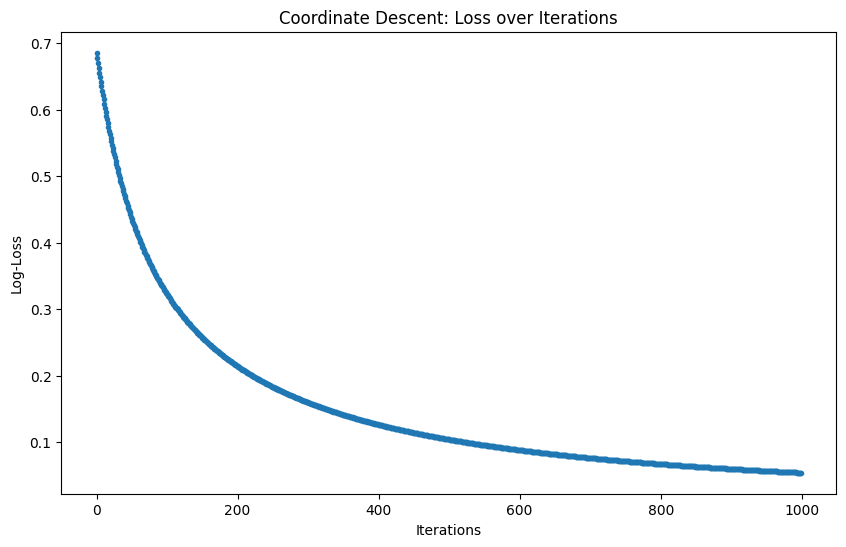

In [9]:
# Define the coordinate descent algorithm with loss tracking
def coordinate_descent_log_loss(X, y, alpha=0.01, num_iters=1000):
    m, n = X.shape
    theta = np.zeros(n)
    losses = []  # List to store loss values for each iteration
    for _ in range(num_iters):
        for j in range(n):
            prediction = sigmoid(X.dot(theta))
            error = prediction - y
            gradient = (1 / m) * X[:, j].dot(error)
            theta[j] -= alpha * gradient
        # Compute and store loss after each iteration
        loss = compute_log_loss(X, y, theta)
        losses.append(loss)
    return theta, losses

# Perform coordinate descent with loss tracking
theta, losses = coordinate_descent_log_loss(X_train, y_train)

# Plot the loss over iterations
plt.figure(figsize=(10, 6))
plt.plot(losses, marker='.', linestyle='-')
plt.xlabel('Iterations')
plt.ylabel('Log-Loss')
plt.title('Coordinate Descent: Loss over Iterations')
plt.show()


# **Comparing Before and After Minimization**

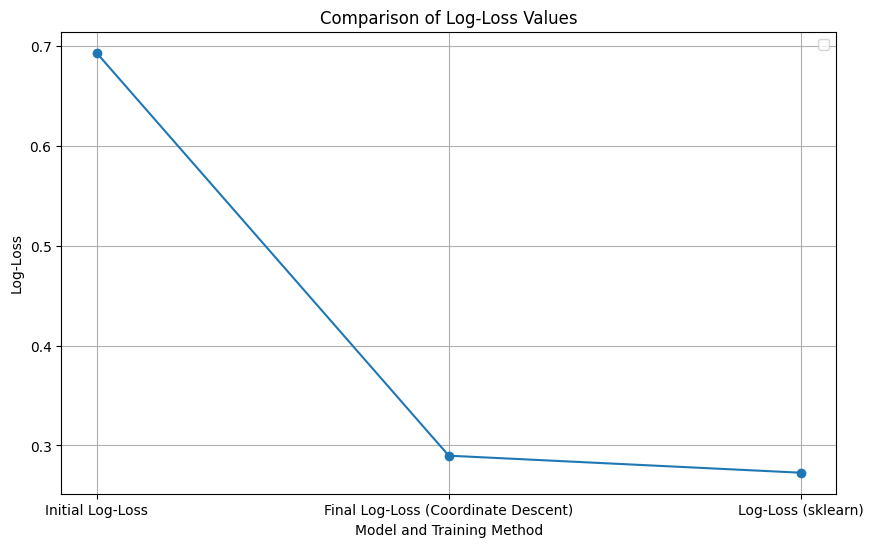

In [10]:
# Loss values
losses = [initial_log_loss, final_log_loss, log_reg_log_loss]
labels = ['Initial Log-Loss', 'Final Log-Loss (Coordinate Descent)', 'Log-Loss (sklearn)']

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(labels, losses, marker='o', linestyle='-')
plt.xlabel('Model and Training Method')
plt.ylabel('Log-Loss')
plt.title('Comparison of Log-Loss Values')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
# Define the gradient descent algorithm to minimize log-loss
def gradient_descent_log_loss(X, y, alpha=0.01, num_iters=5000):
    m, n = X.shape
    theta = np.zeros(n)
    for _ in range(num_iters):
        predictions = sigmoid(X.dot(theta))
        error = predictions - y
        gradient = (1 / m) * X.T.dot(error)
        theta -= alpha * gradient
    return theta

# Define a function to compare the minimized values
def compare_minimized_values(X_train, y_train, X_test, y_test):
    # Perform gradient descent to minimize log-loss
    theta_gradient_descent = gradient_descent_log_loss(X_train, y_train)
    final_log_loss_gradient_descent = compute_log_loss(X_test, y_test, theta_gradient_descent)

    # Print the final log-loss after gradient descent, coordinate desecent and log-loss of logistic regressio from sklearn
    print("Final Log-Loss after Gradient Descent:", final_log_loss_gradient_descent)
    print("Final Log-Loss after Coordinate Descent:", final_log_loss)
    print("Logistic Regression Log-Loss (sklearn):", log_reg_log_loss)

# Call the function to compare minimized values
compare_minimized_values(X_train, y_train, X_test, y_test)


Final Log-Loss after Gradient Descent: 0.24894962995092756
Final Log-Loss after Coordinate Descent: 0.28977450792415127
Logistic Regression Log-Loss (sklearn): 0.27271497896818264


**If you found this notebook helpful and enjoyed my work, please consider giving it an upvote ⬆️. This task was completed as a Complex Engineering Problem (CEP) for my DS221 Inferential Statistics course at the GIK Institute, taught by Dr. Babar Zaman. I'm not very confident with the mathematical aspects, so if you notice any errors, please feel free to make a fork or comment on it to help me improve. The mathematical formulations and LaTeX code were generated by Gemini.  Thank you!**

CC:  ChatGPT, Stackoverflow, stats.stackexchange, GitHub